# Parallel Programming Example

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Python version

In [3]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

Note that we use a 16-fold smaller image for the Python version.

CPU times: user 3.07 s, sys: 0 ns, total: 3.07 s
Wall time: 3.1 s


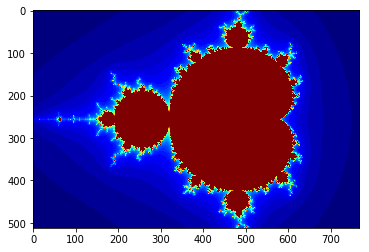

In [4]:
%%time

h, w = 2048//4, 3072//4
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism with `multiprocessing`

In [5]:
import multiprocessing

In [6]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    args = []    
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            args.append((real, imag, iters))
            
    p = multiprocessing.Pool()
    colors = np.array(p.starmap(mandel, args), 'float')
    p.close()
    
    return colors.reshape((width, height)).T

CPU times: user 2.3 s, sys: 180 ms, total: 2.48 s
Wall time: 2.53 s


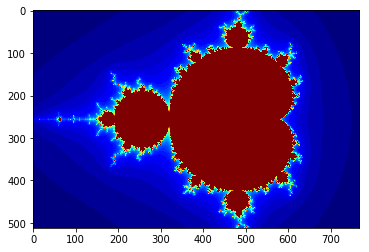

In [7]:
%%time

h, w = 2048//4, 3072//4
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
gimage = create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism in `numba`

In [8]:
from numba import jit, prange

### JIT with `numba`

In [9]:
@jit(nopython=True, cache=True)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

In [10]:
@jit(nopython=True, cache=True)
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

CPU times: user 2.16 s, sys: 28 ms, total: 2.19 s
Wall time: 2.19 s


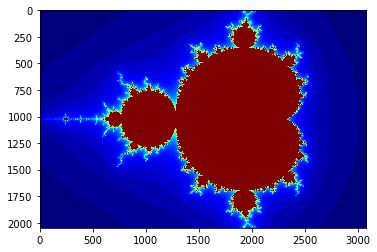

In [11]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

### JIT with `numba` and `prange` using `parallel` option

In [12]:
# function to be run in parallel needs `nogil=True`
@jit(nopython=True, nogil=True)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

@jit(nopython=True, parallel=True)
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    # replace `range` with `prange`
    for x in prange(width):
        real = xmin + x*pixel_size_x
        for y in prange(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

CPU times: user 2.44 s, sys: 4 ms, total: 2.44 s
Wall time: 1.06 s


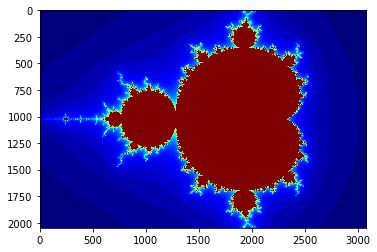

In [13]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism in `cython`

In [14]:
import cython

In [15]:
%load_ext cython

In [16]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

cdef unsigned char mandel_cython(double x, double y, int max_iters):
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(double xmin, double xmax, double ymin, double ymax, 
                          unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color  

CPU times: user 2.16 s, sys: 16 ms, total: 2.17 s
Wall time: 2.17 s


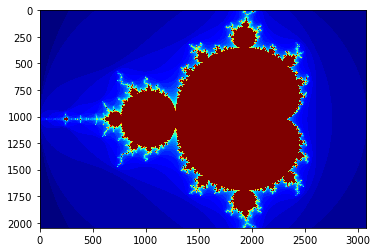

In [17]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

### Parallel version with `cython`

In [18]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

# All cdef functions need to be `nogil`
cdef extern from "complex.h" nogil:
    double cabs(double complex)

# All cdef functions need to be `nogil`
cdef unsigned char mandel_cython(double x, double y, int max_iters) nogil:
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def create_fractal_cython_par(double xmin, double xmax, double ymin, double ymax, 
                              unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
    
    # use prange in parallel, nogil context
    with cython.nogil, parallel():
        for x in prange(width):
            real = xmin + x*pixel_size_x
            for y in prange(height):
                imag = ymin + y*pixel_size_y
                color = mandel_cython(real, imag, iters)
                image[y, x]  = color  

CPU times: user 3.11 s, sys: 12 ms, total: 3.12 s
Wall time: 788 ms


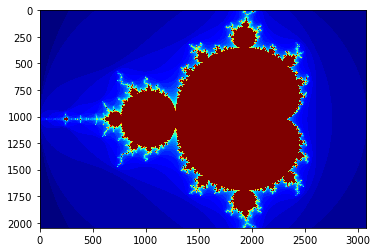

In [19]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal_cython_par(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism using `ipyparallel`

In [3]:
from ipyparallel import Client

In [4]:
rc = Client()
rc.ids

[0, 1, 2, 3]

In [5]:
dv = rc[:]

In [34]:
@dv.parallel(block=True)
@jit(nopython=True, cache=True)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0
    for i in range(max_iters):
        z = z*z + c
        if z.real * z.real + z.imag * z.imag >= 4: # abs(z) >= 4:
            return i
    return max_iters

In [35]:
# @jit(nopython=True, cache=True)
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    args = []    
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            args.append((real, imag, iters))    
    
    colors = np.array(mandel(np.array(args).T), 'float')    
    return colors.reshape((width, height)).T

In [36]:
%%time

h, w = 2048//4, 3072//4
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
gimage = create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

KeyboardInterrupt: 

In [30]:
mandel.map?